# Welcome to the qRBM demo!
In this demo we will go over a simple use case for an RBM that is trained semi-classically, semi-quantumly. To get started, we import our dependencies, we will need pyquil, grove, numpy and scipy. 

In [32]:
import pyquil.api as api
from pyquil import Program
from qRBM_final import qRBM
from pyquil.gates import *
from random import *
import numpy as np
from sklearn import svm
from sklearn.neural_network import BernoulliRBM
from matplotlib import pyplot as plt

## Creating the underlying distribution
We flip an unbiased coin to generate a sequence of random bits, this will be the underlying hidden distribution of our data.

In [33]:
#flip a coin
np.random.seed(1234)
random_coin = np.random.choice([0,1], size=20, replace=True)
random_coin

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [34]:
qvm = api.QVMConnection()
p = Program()
p.inst(H(0), CNOT(0, 1))
r = qRBM(qvm, num_visible=4, num_hidden=1, n_quantum_measurements=None, verbose=True)

## Generating encoded sequences
Code below takes our sequence of random bits and encodes each 1 bit result into a 4 bit representation. This effectively creates artificial data with a 1 bit "needle" (hidden code subspace) in the "haystack" (4-bit data), which our RBM will have to decode. 

In [52]:
#Encode this coin flip in to an artifically high dimensional dataset
artificial_data = []
for flip in random_coin:
    if flip == 1:
        artificial_data.append([-1,-1,1,1]) #logical 1
    else:
        artificial_data.append([1,1,-1,-1]) #logical 0

#We know have an artificially high dimensional dataset that still only has the 1 bit coin flip dictating
#the underlying distribution
artificial_data = np.asarray(artificial_data)
artificial_data

array([[-1, -1,  1,  1],
       [-1, -1,  1,  1],
       [ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1],
       [ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [ 1,  1, -1, -1]])

## Creating and training our qRBM

In [53]:
#We will now setup our RBM to try and understand the artifical data's underlying distribution

#we will use "analytical" measurement to save time on simulation.
qr = qRBM(qvm, num_visible=4, num_hidden=1,n_quantum_measurements=None)

In [54]:
%%capture
#let it train...
qr.train(artificial_data,n_epochs=8)

## Comparing RBM-decoded data to originally encoded data
In the following code snippet we examine the hidden unit activation probabilities and how they correspond to the initial information from the coin flip. As we can see the probability of the hiddens corresponds very well with the flip.

In [55]:
#Now that the training is done (~5 mins when doing analytical expectation)
# we can transform our data to the hidden layer
transformed = qr.transform(artificial_data)

comparison = np.stack((transformed[:,0], random_coin))

#compare our rbm probabilities with the coin flips.
print ('RBM Pr. | Original Coin Value')
print ('-'*20)
for i in range(len(transformed)):
    print ('{: 0.3f}'.format(float(comparison[:,i][0])), ' |', '{: 0.3f}'.format(comparison[:,i][1]))


RBM Pr. | Original Coin Value
--------------------
 0.576  |  1.000
 0.576  |  1.000
 0.424  |  0.000
 0.576  |  1.000
 0.424  |  0.000
 0.424  |  0.000
 0.424  |  0.000
 0.576  |  1.000
 0.576  |  1.000
 0.576  |  1.000
 0.576  |  1.000
 0.576  |  1.000
 0.424  |  0.000
 0.424  |  0.000
 0.576  |  1.000
 0.424  |  0.000
 0.424  |  0.000
 0.424  |  0.000
 0.424  |  0.000
 0.424  |  0.000


### Use a discriminative model with the hidden states of QRBM to evaluate the QRBM

In [56]:
def quantum_rbm_eval(num_epochs, hidden_model_list, hidden_state):
    y = random_coin
    scores = []
    for epoch in range(num_epochs):
        X = hidden_model_list[hidden_state].pred_list[epoch]
        clf = svm.SVC()
        clf.fit(X, y)
        scores.append([clf.score(X,y)])
    return scores

In [57]:
qr.pred_list

[array([[0.56332904],
        [0.56332904],
        [0.43667096],
        [0.56332904],
        [0.43667096],
        [0.43667096],
        [0.43667096],
        [0.56332904],
        [0.56332904],
        [0.56332904],
        [0.56332904],
        [0.56332904],
        [0.43667096],
        [0.43667096],
        [0.56332904],
        [0.43667096],
        [0.43667096],
        [0.43667096],
        [0.43667096],
        [0.43667096]]),
 array([[0.56464011],
        [0.56464011],
        [0.43535989],
        [0.56464011],
        [0.43535989],
        [0.43535989],
        [0.43535989],
        [0.56464011],
        [0.56464011],
        [0.56464011],
        [0.56464011],
        [0.56464011],
        [0.43535989],
        [0.43535989],
        [0.56464011],
        [0.43535989],
        [0.43535989],
        [0.43535989],
        [0.43535989],
        [0.43535989]]),
 array([[0.56607911],
        [0.56607911],
        [0.43392089],
        [0.56607911],
        [0.43392089],
      

In [58]:
scores = quantum_rbm_eval(num_epochs=20, hidden_model_list=[qr], hidden_state=0)

IndexError: list index out of range

In [24]:
def plot_score(score_list, hidden_state):
    plt.plot(score_list, marker='o', label="Hidden State: " + str(hidden_state))
    # plt.ylim(0, 1)
    plt.xlabel('# Epochs')
    plt.ylabel('Accuracy')
    plt.title('Hidden States: Accuracy vs Epochs') 
    plt.legend()
    plt.ylim(0, 1.1)
#     plt.xlim(0, 20)

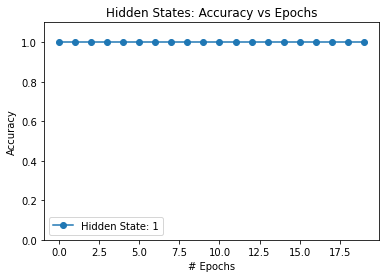

In [25]:
plot_score(scores, 1)

# Thank you!
Check out 
https://github.com/MichaelBroughton/QABoM.
For a baseline version of this code that you can experiment with for yourself.